In [1]:
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt

# Load data

## Cis proteins

In [2]:
# Remember: this dataset has disordered (d) and structured (s) CREs
cre_dataset = pd.read_csv('../datasets/cre_dataset.csv')

## SIFT data
The Structure Integration with Function, Taxonomy and Sequences resource (SIFTS; http://pdbe.org/sifts) is a close collaboration between the Protein Data Bank in Europe (PDBe) and UniProt. The two teams have developed a semi-automated process for maintaining up-to-date cross-reference information to UniProt entries, for all protein chains in the PDB entries present in the UniProt database.

In [3]:
# Mapping Uniport_acc and its PDBs
# UniProt to PDB mappings showing the UniProt accession followed by a semicolon-separated list of PDB four letter codes (https://www.ebi.ac.uk/pdbe/docs/sifts/quick.html)
uniprot_pdb = pd.read_csv('../raw_data/uniprot_pdb.tsv.gz', sep= '\t', compression= 'gzip', skiprows=1)
# PDBs chains
pdb_chain_uniprot = pd.read_csv('../raw_data/pdb_chain_uniprot.tsv.gz', sep= '\t', compression= 'gzip', skiprows=1)

In [4]:
# UniProt to PDBe residue level mapping (observed residues only), 
# showing the start and end residues of the mapping using SEQRES, PDB sequence and UniProt numbering.
pdb_segments = pd.read_csv('../raw_data/uniprot_segments_observed.tsv.gz', sep= '\t', skiprows= 1, compression= 'gzip')
pdb_segments.columns = pdb_segments.columns.str.lower()
pdb_segments

,pdb,chain,sp_primary,res_beg,res_end,pdb_beg,pdb_end,sp_beg,sp_end
0,1wfc,A,Q16539,11,19,5,13,5,13
1,1wfc,A,Q16539,22,175,16,169,16,169
2,1wfc,A,Q16539,181,357,175,351,175,351
3,6aek,A,P06802,3,453,170,620,170,620
4,6aek,A,P06802,462,462,629,629,629,629
...,...,...,...,...,...,...,...,...,...
960081,7liw,B,P53396,2,139,2,139,2,139
960082,7liw,B,P53396,149,431,149,431,149,431
960083,7liw,B,P53396,487,1099,487,1099,487,1099
960084,7liw,C,P53396,821,1099,821,1099,821,1099


In [5]:
pdb_segments[pdb_segments.pdb == '102l']

,pdb,chain,sp_primary,res_beg,res_end,pdb_beg,pdb_end,sp_beg,sp_end
679165,102l,A,P00720,1,163,1,162,1,162


In [5]:
# For the start and end coordinates take sp_beg and sp_end cols, that corresponds to uniprot sequence positions
pdb_segments = pdb_segments[['sp_primary', 'pdb', 'chain', 'sp_beg', 'sp_end']]
pdb_segments.rename(columns= {'sp_primary': 'uniprot_acc', 'sp_beg': 'start', 'sp_end': 'end'}, inplace= True)

c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
# Subset for CRE proteins
pdb_segments = pdb_segments[pdb_segments.uniprot_acc.isin(cre_dataset.uniprot_acc.unique())]
pdb_segments.shape

(8022, 5)

In [7]:
pdb_segments.uniprot_acc.nunique()

123

to do: analyze overlap between pdb segments and cis elements  
then, don't forget to split between positive and negative proteins

## Check overlap between CREs and PDBs

In [8]:
# df with the ranges for each CRE. Rename cols for pyranges
cre_ranges = cre_dataset[['uniprot_acc', 'id_cre', 'start_aa', 'end_aa']].rename(
    columns={'uniprot_acc': 'Chromosome', 'start_aa': 'Start', 'end_aa': 'End'}
)

In [9]:
# As pyranges object
cre_ranges = pr.PyRanges(cre_ranges)

In [10]:
cre_ranges

,Chromosome,id_cre,Start,End
0,A8KAM8,43,1006,1106
1,C8ZE58,15,604,741
2,O08722,124,544,688
3,O08808,72,1180,1199
4,O08967,54,251,266
...,...,...,...,...
163,Q63622,86,158,408
164,Q64287,83,410,439
165,Q92985,134,404,466
166,Q93107,14,91,157


In [11]:
# Now pdbs with their ranges
pdb_ranges = pdb_segments[['uniprot_acc', 'pdb', 'start', 'end']].rename(
    columns = {'uniprot_acc': 'Chromosome'}
)
pdb_ranges.columns = pdb_ranges.columns.str.capitalize()
# As pyranges object
pdb_ranges = pr.PyRanges(pdb_ranges)

In [12]:
# Count overlaps
overlap = cre_ranges.count_overlaps(pdb_ranges, overlap_col = 'overlap_count')

In [51]:
# to dataframe
overlap_df = overlap.as_df()
overlap_df.sort_values("overlap_count")

,Chromosome,id_cre,Start,End,overlap_count
0,A8KAM8,43,1006,1106,0
104,Q8VDP3,60,761,1048,0
102,Q8IVH8,89,511,735,0
101,Q6FI27,30,3,54,0
100,Q5VT25,28,658,930,0
...,...,...,...,...,...
18,P00519,110,61,233,96
19,P00523,8,88,248,107
138,Q06124,153,6,81,125
20,P00523,9,520,533,139


In [14]:
(overlap_df.overlap_count > 0).sum()

97

<AxesSubplot:>

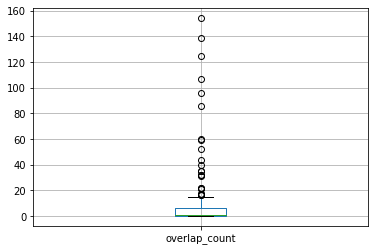

In [15]:
overlap_df[['overlap_count']].boxplot()

In [16]:
# Check one example
cre_dataset[cre_dataset.uniprot_acc == 'P04629'] # is structured

,name,uniprot_acc,species,references,module,start_aa,end_aa,dataset,id_cre
96,NTRK1,P04629,H. sapiens,"(Arevalo et al., 2000)",s,287,384,train,97


In [17]:
pdb_segments.loc[(pdb_segments.uniprot_acc == 'P04629') & (pdb_segments.end <= 384)] # 10, OK

,uniprot_acc,pdb,chain,start,end
62666,P04629,1www,X,282,382
62667,P04629,1www,Y,282,382
340591,P04629,1wwa,Y,278,382
415647,P04629,2ifg,A,36,382
415648,P04629,2ifg,B,36,382
429335,P04629,7n3t,A,36,382
429336,P04629,7n3t,B,36,201
429337,P04629,7n3t,B,204,382
541112,P04629,4crp,A,279,279
541113,P04629,4crp,A,282,383


In [19]:
# check a disoredered example
cre_dataset[cre_dataset.module == 'd']

,name,uniprot_acc,species,references,module,start_aa,end_aa,dataset,id_cre
0,DNMT1,P13864,M. musculus,"(Song et al., 2011; Trudeau et al., 2013)",d,699,733,train,1
1,TBP,P20226,H. sapiens,"(Kuddus and Schmidt, 1993; Trudeau et al., 2013)",d,1,55,train,2
2,TAK1,Q62073,M. musculus,"(Yamaguchi et al., 1995)",d,1,22,train,3
3,SNF1,P06782,S. crevisiae,"(Jiang and Carlson, 1997; Trudeau et al., 2013)",d,392,495,train,4
4,TSE1,P10644,H. sapiens,"(Francis et al., 2002)",d,1,98,train,5
...,...,...,...,...,...,...,...,...,...
146,p65,Q04206,H. sapiens,"(Trudeau et al., 2013)",d,313,550,test,147
147,Zyxin,Q15942,H. sapiens,"(Hansen and Kwiatkowski, 2013)",d,1,130,test,148
148,PLCβ3,Q01970,H. sapiens,"(Lyon et al., 2014)",d,471,575,test,149
149,RAD26 homolog,Q9UR24,S. pombe,"(Wang et al., 2014)",d,825,973,test,150


In [18]:
# A disordered example: Q04206
x = pdb_segments.loc[(pdb_segments.uniprot_acc == 'Q04206') & (pdb_segments.end <= 384)]
x

,uniprot_acc,pdb,chain,start,end
6413,Q04206,7let,C,299,304
12449,Q04206,6yp3,P,43,51
15528,Q04206,7nmh,P,43,51
30679,Q04206,6yp2,P,43,51
56484,Q04206,3rc0,P,307,312
...,...,...,...,...,...
908780,Q04206,7njb,P,43,51
919076,Q04206,7nxw,P,43,51
924405,Q04206,7biw,P,43,51
938048,Q04206,7bkh,P,43,51


### Subset only for disordered CREs

In [39]:
ids = cre_dataset[cre_dataset.module == 'd'].id_cre.to_list()

In [41]:
overlap_disorder = overlap_df[overlap_df.id_cre.isin(ids)]
overlap_disorder.shape

(94, 5)

<AxesSubplot:>

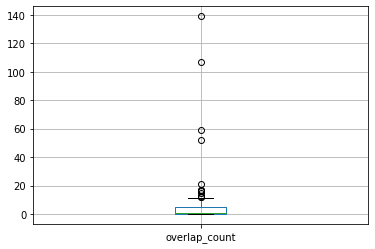

In [46]:
overlap_disorder[['overlap_count']].boxplot()

In [52]:
overlap_df.columns = overlap_df.columns.str.lower()
overlap_df.rename(columns= {'chromosome': 'uniprot_acc', 'overlap_count': 'no_pdbs'}, inplace= True)

In [53]:
#overlap_df.to_csv('../datasets/cre_pdb_count.tsv', sep='\t', index = False)

---

### Subset only for our proteins

In [20]:
uniprot_pdb = uniprot_pdb[uniprot_pdb.SP_PRIMARY.isin(cre_dataset.uniprot_acc)]
# Splits PDBs by the ";" and then explode
uniprot_pdb.PDB = uniprot_pdb.PDB.str.split(';')
uniprot_pdb = uniprot_pdb.explode("PDB")
uniprot_pdb.rename(columns= {'SP_PRIMARY': 'uniprot_acc', 'PDB': 'pdb'}, inplace= True)
uniprot_pdb.shape

(2486, 2)

In [21]:
pdb_chain_uniprot = pdb_chain_uniprot[pdb_chain_uniprot.SP_PRIMARY.isin(cre_dataset.uniprot_acc)]
pdb_chain_uniprot.shape

(4425, 9)

In [22]:
uniprot_pdb

,uniprot_acc,pdb
15592,O08722,3g5b
15602,O08808,4uwx
15602,O08808,1z2c
15602,O08808,3eg5
15602,O08808,2bnx
...,...,...
57635,Q9Y613,6xf1
57635,Q9Y613,3dad
57635,Q9Y613,6xf2
57843,Q9Z0R4,3jv3


In [23]:
pdb_chain_uniprot.columns.str.lower()

Index(['pdb', 'chain', 'sp_primary', 'res_beg', 'res_end', 'pdb_beg',
       'pdb_end', 'sp_beg', 'sp_end'],
      dtype='object')

### Add proteins info

In [61]:
data = cre_dataset[['uniprot_acc', 'name', 'module']].drop_duplicates()

In [62]:
data

,uniprot_acc,name,module
0,P13864,DNMT1,d
1,P20226,TBP,d
2,Q62073,TAK1,d
3,P06782,SNF1,d
4,P10644,TSE1,d
...,...,...,...
163,Q3UP24,NLRC4,s
164,Q9JK66,Park2,s
165,Q15691,EB1,s
166,P04521,gp47,s


In [63]:
uniprot_pdb = uniprot_pdb.merge(data, how= 'left')
uniprot_pdb.sort_values('uniprot_acc', inplace= True)

### How many proteins have a PDB acc?

In [64]:
uniprot_pdb.uniprot_acc.nunique()

123

In [28]:
# overlap_df[overlap_df.overlap_count > 0].Chromosome.nunique()
# 91, esta ok. No tienen que ser iguales, alguna proteina podria tener pdbs que no solapan con el cre.

In [65]:
# How many of the 81 positive proteins have structures?
positive_prot = cre_dataset[cre_dataset.module == 'd'].uniprot_acc
positive_prot = uniprot_pdb[uniprot_pdb.uniprot_acc.isin(positive_prot)]

In [66]:
positive_prot.uniprot_acc.nunique()

61

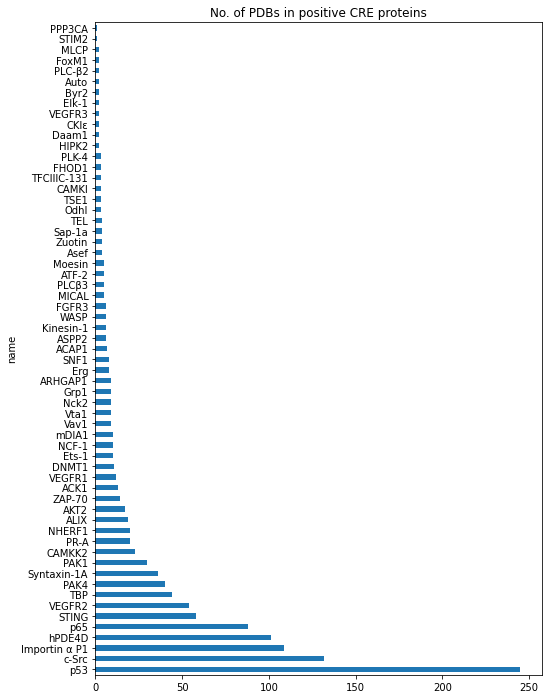

In [31]:
plt.figure(figsize= (8,12))
positive_prot.groupby('name').size().sort_values(ascending= False).plot(kind='barh')
plt.title("No. of PDBs in positive CRE proteins")
plt.show()

In [67]:
uniprot_pdb

,uniprot_acc,pdb,name,module
0,O08722,3g5b,UNC5b,s
1,O08808,4uwx,mDIA1,d
2,O08808,1z2c,mDIA1,d
3,O08808,3eg5,mDIA1,d
4,O08808,2bnx,mDIA1,d
...,...,...,...,...
2481,Q9Y613,6xf1,FHOD1,d
2482,Q9Y613,3dad,FHOD1,d
2483,Q9Y613,6xf2,FHOD1,d
2484,Q9Z0R4,3jv3,Intersectin-1L,s


In [33]:
#uniprot_pdb.to_csv('../datasets/uniprot_pdb.tsv', sep= '\t', header= True, index= False)